<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nyandwi/machine_learning_complete/blob/main/6_classical_machine_learning_with_scikit-learn/8_random_forests_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

*This notebook was created by [Jean de Dieu Nyandwi](https://twitter.com/jeande_d) for the love of machine learning community. For any feedback, errors or suggestion, he can be reached on email (johnjw7084 at gmail dot com), [Twitter](https://twitter.com/jeande_d), or [LinkedIn](https://linkedin.com/in/nyandwi).*

<a name='0'></a>
# 6.8 Random Forests - Classification

Random Forests are powerful machine learning algorithms used for supervised classification and regression. Random forests works by averaging the predictions of the multiple and randomized decision trees. Decision trees tends to overfit and so by combining multiple decision trees, the effect of overfitting can be minimized. 

Random Forests are type of ensemble models. More about ensembles models in the next notebook. 

Different to other learning algorithms, random forests provide a way to find the importance of each feature and this is implemented in Sklearn. 

## Random Forests for Classification

### Contents

* [1 - Imports](#1)
* [2 - Loading the data](#2)
* [3 - Exploratory Analysis](#3)
* [4 - Preprocessing the data](#4)
* [5 - Training Random Forests Classifier](#5)
* [6 - Evaluating Random Forests Classifier](#6)
* [7 - Improving Random Forests Classifier](#7)
* [8 - Evaluating the Improved Model on the Test Set ](#8)
* [9 - Feature Importance](#9)

<a name='1'></a>
## 1 - Imports

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

<a name='2'></a>

## 2 - Loading the data

In this notebook, we will use Random forests to build a classifier that identify the increase or decrease of the electricity using "the data that was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations."

"The dataset contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends). Source: [Open ML electricity](https://www.openml.org/d/151).

Here are the information about the features:

* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1 
* Day: day of the week (1-7) 
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1 
* NSWprice: New South Wales electricity price, normalized between 0 and 1 
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1 
* VICprice: Victoria electricity price, normalized between 0 and 1 
* VICdemand: Victoria electricity demand, normalized between 0 and 1 
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1 


Let's load the dataset using Sklearn `fetch_ml function`. 

In [1]:
# Let's hide warnings

import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.datasets import fetch_openml

elec_data = fetch_openml(name='electricity', version=1)

In [7]:
type(elec_data)

sklearn.utils.Bunch

In [8]:
elec_data.details

{'id': '151',
 'name': 'electricity',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['M. Harries', 'J. Gama', 'A. Bifet'],
 'collection_date': '1998-12-05',
 'upload_date': '2014-04-10T02:42:23',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/2419/electricity.arff',
 'file_id': '2419',
 'default_target_attribute': 'class',
 'version_label': '1',
 'tag': ['AzurePilot',
  'concept_drift',
  'electricity',
  'mythbusting_1',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_135',
  'study_14',
  'study_15',
  'study_16',
  'study_20',
  'study_34',
  'study_37',
  'study_41',
  'study_7',
  'study_70',
  'study_99'],
 'visibility': 'public',
 'original_data_url': 'http://www.inescporto.pt/~jgama/ales/ales_5.html',
 'paper_url': 'http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.43.9013',
 'minio_url': 'http://openml1.win.tue.nl/dataset151/dataset_151.pq',
 'status': 'active',
 'processi

In [9]:
elec_data.data.shape

(45312, 8)

In [11]:
# Description of the data 
#print(elec_data.DESCR)

In [12]:
# Displaying feature names

elec_data.feature_names

['date',
 'day',
 'period',
 'nswprice',
 'nswdemand',
 'vicprice',
 'vicdemand',
 'transfer']

In [13]:
# Displaying target name

elec_data.target_names

['class']

In [14]:
# Getting the whole dataframe

elec_df = elec_data.frame

In [15]:
type(elec_df )

pandas.core.frame.DataFrame

<a name='3'></a>
## 3 - Exploratory Data Analysis


Before doing exploratory analysis, as always, let's split the data into training and test sets. 

In [17]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(elec_df , test_size=0.25,random_state=20)

print('The size of training data is: {} \nThe size of testing data is: {}'.format(len(train_data), len(test_data)))

The size of training data is: 33984 
The size of testing data is: 11328


### Taking a quick look into the dataset

In [22]:
train_data.head(10)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
27325,0.469846,4,0.276596,0.164705,0.519637,0.011417,0.657949,0.265789,DOWN
28731,0.474227,5,0.574468,0.024919,0.191907,0.001656,0.090886,0.819737,DOWN
8450,0.023141,3,0.042553,0.065270,0.250074,0.003467,0.422915,0.414912,DOWN
36659,0.889385,2,0.744681,0.148193,0.670039,0.009981,0.533402,0.563596,UP
781,0.000708,4,0.276596,0.124204,0.475454,0.003467,0.422915,0.414912,UP
13013,0.428963,7,0.106383,0.055242,0.084647,0.003467,0.422915,0.414912,DOWN
3330,0.009203,1,0.382979,0.045635,0.741892,0.003467,0.422915,0.414912,DOWN
18851,0.446662,2,0.744681,0.183409,0.785034,0.012154,0.757639,0.517105,UP
14838,0.433830,3,0.127660,0.047886,0.141476,0.003467,0.422915,0.414912,DOWN
30462,0.868236,6,0.638298,0.030833,0.702023,0.001963,0.538322,0.674123,UP


In [24]:
# Displaying the last rows 

train_data.tail()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
31962,0.875846,2,0.893617,0.028822,0.427998,0.001288,0.385293,0.813158,DOWN
23452,0.460112,7,0.595745,0.026660,0.369979,0.001774,0.234076,0.621053,DOWN
23775,0.460422,7,0.319149,0.026750,0.373550,0.001813,0.269032,0.564035,DOWN
37135,0.889828,5,0.659574,0.028462,0.555638,0.002021,0.625583,0.248684,DOWN
27098,0.469625,6,0.553191,0.054792,0.514430,0.003712,0.545572,0.229825,UP


In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33984 entries, 27325 to 27098
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       33984 non-null  float64 
 1   day        33984 non-null  category
 2   period     33984 non-null  float64 
 3   nswprice   33984 non-null  float64 
 4   nswdemand  33984 non-null  float64 
 5   vicprice   33984 non-null  float64 
 6   vicdemand  33984 non-null  float64 
 7   transfer   33984 non-null  float64 
 8   class      33984 non-null  category
dtypes: category(2), float64(7)
memory usage: 2.1 MB


Two things to draw from the dataset for now:

* The target feature `class` is categorical. We will make sure to encode that during data preprocessing. 
* All numerical features are already normalized, so we won't need to normalize these type of features.

### Checking Summary Statistics

In [27]:
# Summary stats

train_data.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000,33984.000000
mean,0.498150,0.499211,0.057922,0.424763,0.003445,0.423035,0.500089
std,0.340429,0.294571,0.040195,0.163858,0.008846,0.121087,0.153224
min,0.000000,0.000000,0.000000,0.001190,0.000000,0.000000,0.000000
25%,0.031857,0.234043,0.035247,0.307944,0.002283,0.372087,0.414912
50%,0.456307,0.489362,0.048667,0.442725,0.003467,0.422915,0.414912
75%,0.880581,0.744681,0.074276,0.535704,0.003467,0.469446,0.605263
max,1.000000,1.000000,0.981806,1.000000,1.000000,1.000000,1.000000


### Checking Missing Values

In [28]:
# Checking missing values

train_data.isnull().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

Great, we don't have any missing values. Usually there are three things to do with if them if they are present:
* We can remove all missing values completely
* We can leave them as they are or
* We can fill them with a given strategy such as mean, media or most frequent value. Either `Sklearn` or Pandas provides a quick ways to fill these kind of values. 

For a full guide on handling missing values, I wrote [a comprehensive article](https://medium.com/analytics-vidhya/a-comprehensive-guide-for-handling-missing-values-990c999c49ed?source=---------11----------------------------) a while back but one thing to note is that none of the above techniques is best than others. It depends on the size of your data, and your goal. Removing missing values is loosing data, and filling missing values is adding the noise in the data. 

### Checking Correlation

In [30]:
# Checking feature correlation

corr = train_data.corr()

<AxesSubplot:>

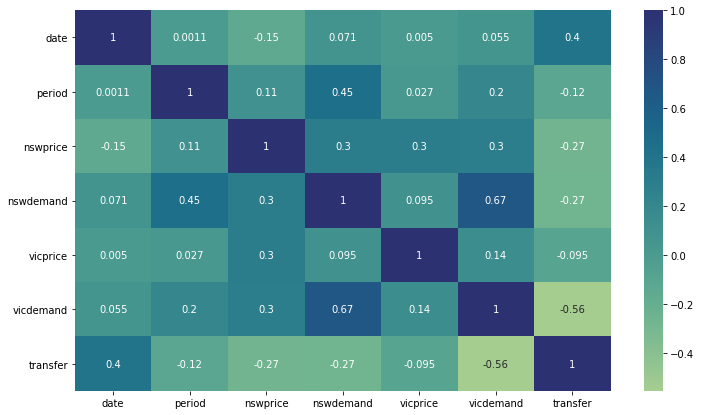

In [31]:
## Visualizing correlation

plt.figure(figsize=(12,7))

sns.heatmap(corr,annot=True,cmap='crest')

It seems that we don't have features which are too correlating. Correlation shown above varies from `-1 to 1`. If the correlation between two features is close to 1, it means that they nearly contain the same information. If it is close to -1, it means that these features contain different information.Take an example: `vicdemand` correlate with `nswdeman` at 0.67 ratio. 

So if you drop one of those features, it's likely that your model will not be affected much. So different to what you have seen in many articles, having features which does not correlate to the target feature doesn't mean they are not useful. 

In the above correlation matrix, you can see that class feature is not there and this is because it still has categorical values. 

### More Data Exploration

Before preprocessing the data, let's take a look into specific features. 

Let's see how many Ups/Downs are in the class feature.

<AxesSubplot:xlabel='class', ylabel='count'>

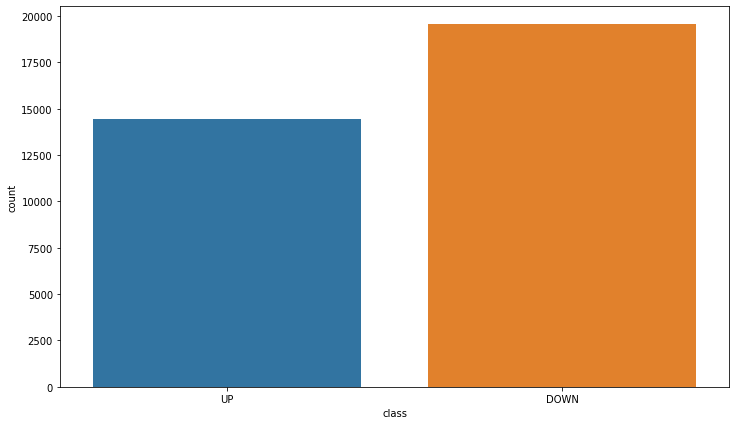

In [107]:
plt.figure(figsize=(12,7))
sns.countplot(data=train_data, x='class')

`Day` is the days of the week, from 1-7, Monday to Sunday. Let's count the days occurences in respect to the ups/downs of the electricity's price.

<AxesSubplot:xlabel='day', ylabel='count'>

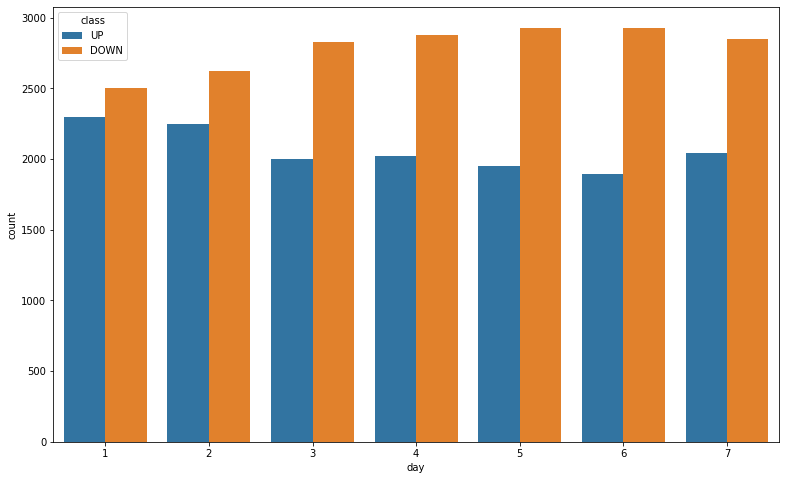

In [44]:
plt.figure(figsize=(13,8))

sns.countplot(data=train_data, x='day', hue='class')

It seems that most days had downs. From the beginning of the week, there were consistent increase in downs(price of electricity went down) and decrease in ups. I am thinking: If we talk to somoene who stays in South Wales, maybe our analysis can make sense. 

Let's see if there is an appealing relationship between the demand/price of electricity in New South Wales and Victoria.

<AxesSubplot:xlabel='vicdemand', ylabel='nswdemand'>

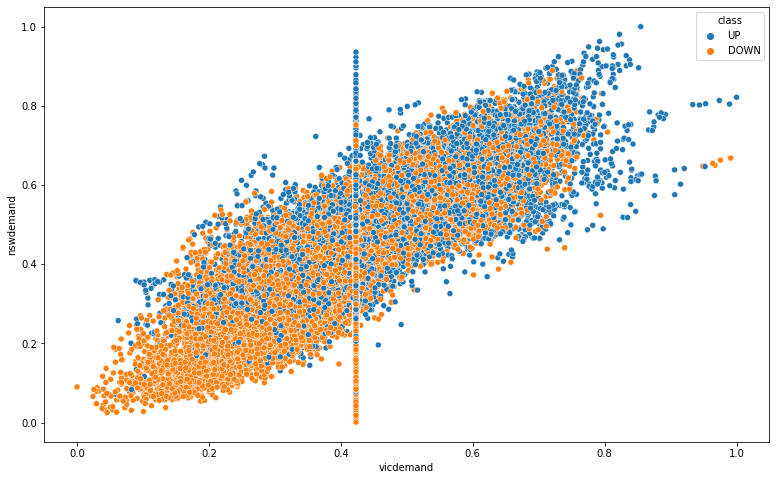

In [50]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=train_data, x='vicdemand', y='nswdemand', hue='class')

The demand of the electricity in New South Wales and the Victoria is kind of linear. Let's see if we can get any other insights by bringing days in the demand analysis.

<AxesSubplot:xlabel='vicdemand', ylabel='nswdemand'>

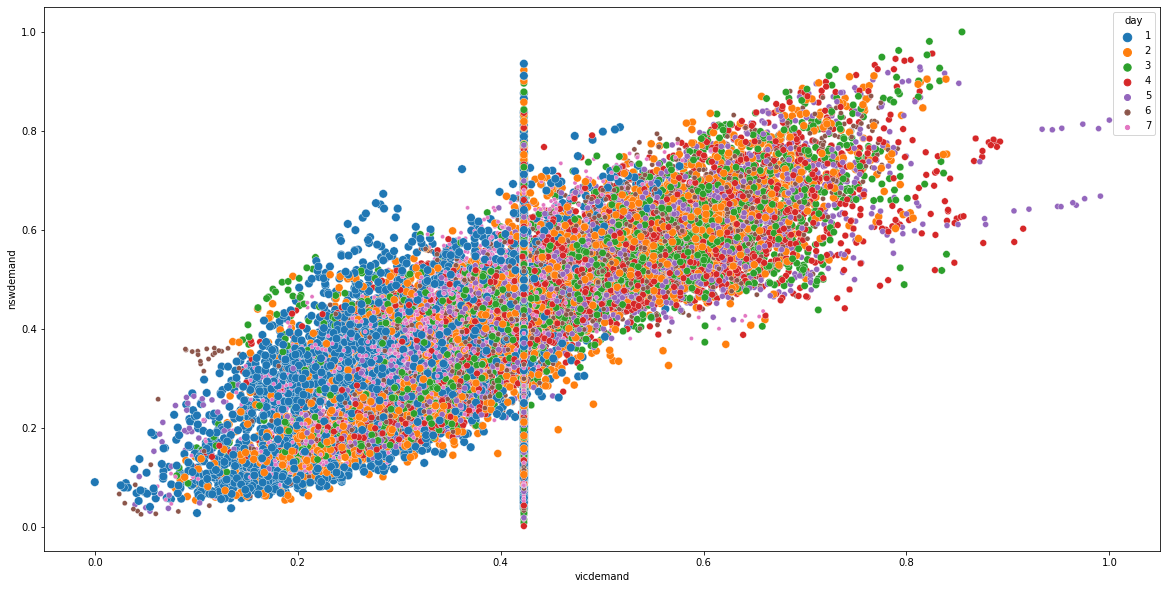

In [61]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=train_data, x='vicdemand', y='nswdemand', hue='day', size='day')

Although it is kind of hard to draw a strong point, there is less demand of electricity in both cities on Monday and Sunday than other days. We can use a line plot to plot the demand in both cities on the course of the days. 

<AxesSubplot:xlabel='day', ylabel='nswdemand'>

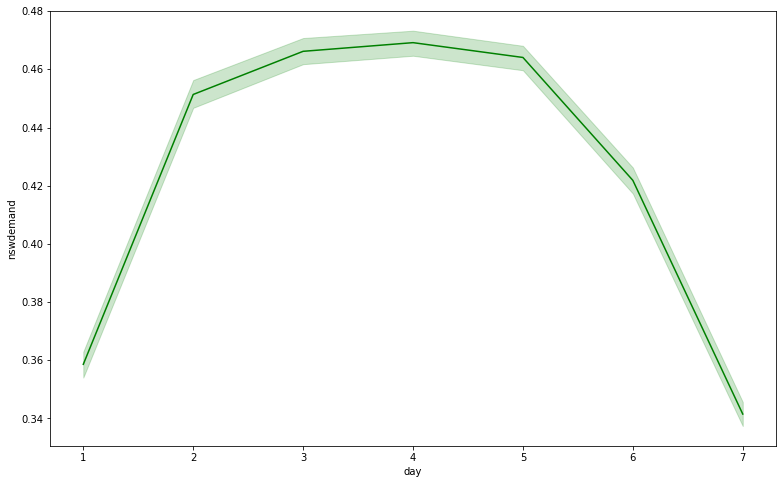

In [77]:
plt.figure(figsize=(13,8))
sns.lineplot(data=train_data, x='day', y='nswdemand', color='green')

<AxesSubplot:xlabel='day', ylabel='vicdemand'>

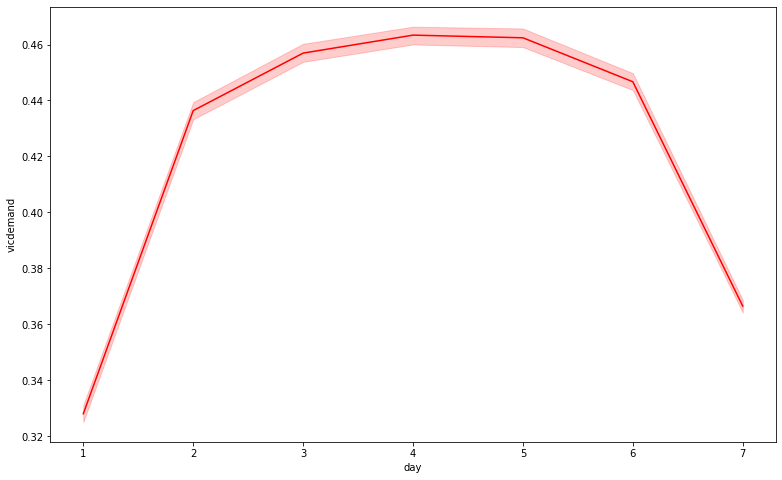

In [78]:
plt.figure(figsize=(13,8))
sns.lineplot(data=train_data, x='day', y='vicdemand', color='red')

Another interesting thing to look in the dataset is if there are some seasonalities/trends in the demand/price in either Victoria or New South Wales over period of time. In time series analysis, seasonality is when there is repetitive scenarios or consistent behaviours over the course of time. Take a different example: It has been observed that the shopping sites experience a consistent increase of page visitors at weekends. That type of example is seasonal: it always happens and in the same way, same amount, and same period.

On the other hand, the trend is a prolonged increase/decrease in a given attribute. A classic example of this is Moore's law which predicted that the number of transistors will double every two years, and that has happened 100% for so long, last 50 years or so. Moore's law were backed by the advent of microprocessors and the need of computation power. That is a trend. 

In the real-life, you can have trends mixed with seasonalities. And sometimes noise can come into the picture. 

I wanted to go deep to explain these time series terms, but le's come back to our analysis. If you look at the demand of the electricity in both cities on the course of date (`7 May 1996 to 5 December 1998`), you can see that there are some types of seasonalities. Not 100% but it seems there is and if this dataset would have been collected for more than two years, it would probably be easy to know surely if there are seasonalities. 

<AxesSubplot:xlabel='date', ylabel='nswdemand'>

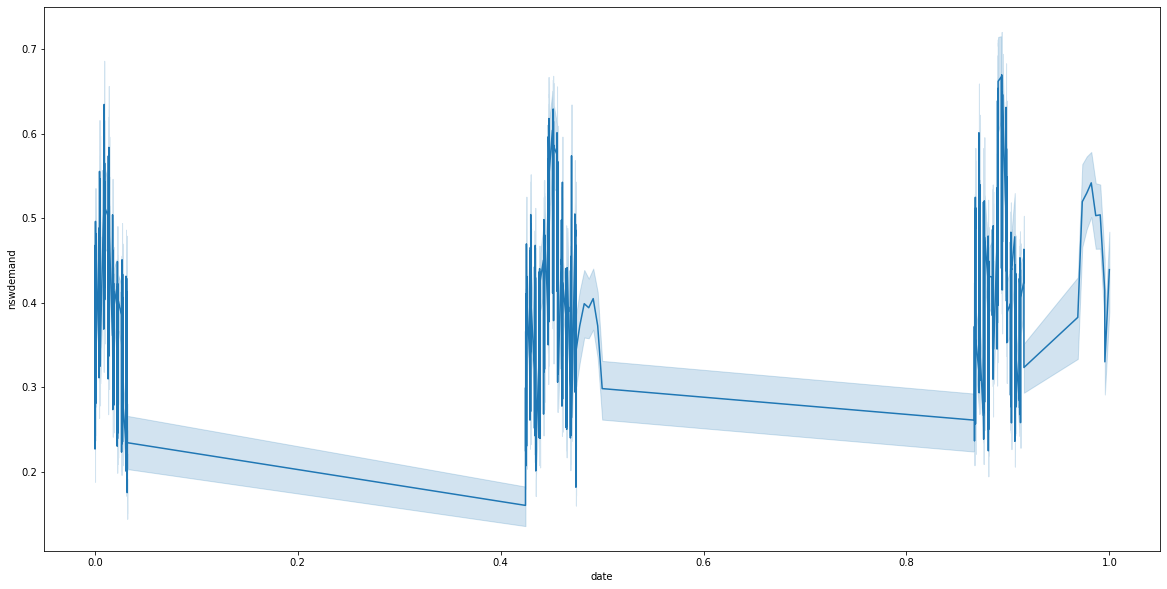

In [64]:
plt.figure(figsize=(20,10))
sns.lineplot(data=train_data, x='date', y='nswdemand')

<AxesSubplot:xlabel='date', ylabel='vicdemand'>

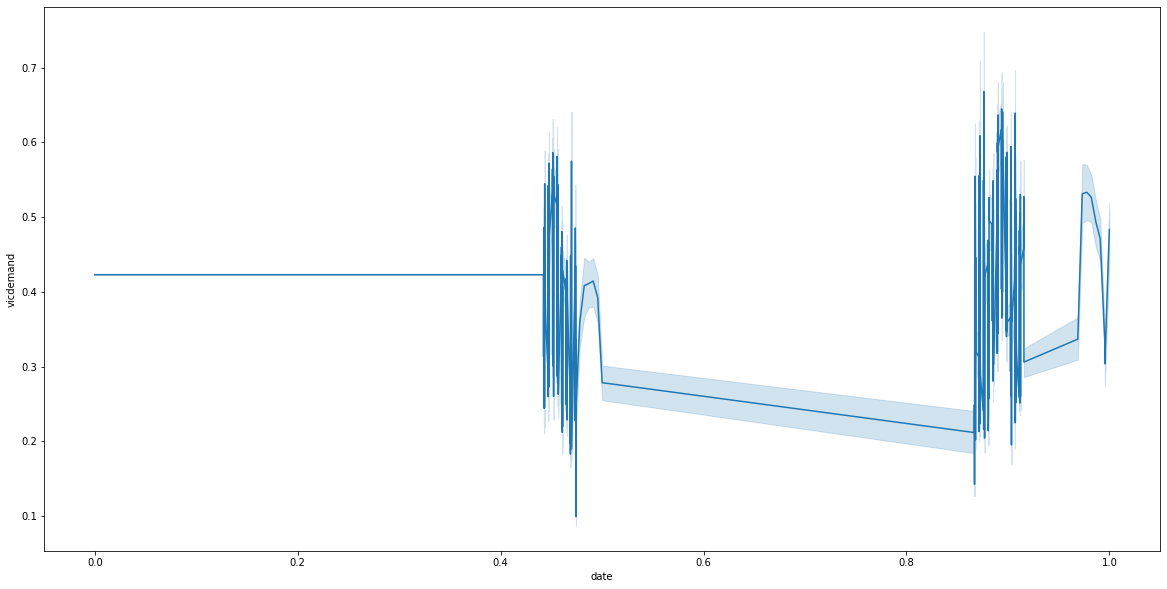

In [65]:
plt.figure(figsize=(20,10))
sns.lineplot(data=train_data, x='date', y='vicdemand')

One last thing about data analysis, let's plot all histograms of the numerical features. 

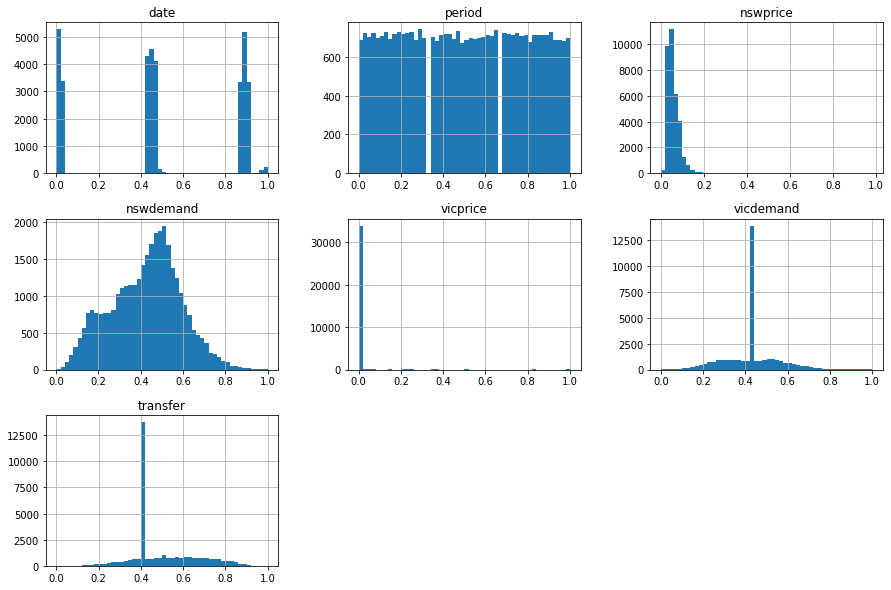

In [80]:
train_data.hist(bins=50, figsize=(15,10))
plt.show()

<a name='4'></a>

## 4 - Data Preprocessing 

It is here that we prepare the data to be in the proper format for the machine learning model. 

Let's encode the categorical feature `class`. But before that, let's take training input data and labels.

In [89]:
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

In [91]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y_train_prepared = label_enc.fit_transform(y_train)

Now we are ready to train the machine learning model. 

But again if you look at the dat, the `day` feature is not normalized as other features. We can normalize it or leave it but for now let's go ahead and train the random forests classifier. 

<a name='5'></a>

## 5 - Training Random Forests Classifier


In [92]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(min_samples_split=2,bootstrap=False, max_depth=None, random_state=42,n_jobs=-1, max_features='sqrt')

forest_clf.fit(X_train, y_train_prepared)

RandomForestClassifier(bootstrap=False, max_features='sqrt', n_jobs=-1,
                       random_state=42)

In [102]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()

forest_clf.fit(X_train, y_train_prepared)

RandomForestClassifier()

<a name='6'></a>

## 6 - Evaluating Random Forests Classifier

Let's build 3 functions to display accuracy, confusion matrix, and classification report. 

* Accuracy provide a percentage score of the model's ability to make correct predictions
* Confusion matrix shows the predicted and the actual classes...True Negativse(TN), True Positives(TP), False Negatives(FN), and True Positives(TP). 
* Classification report contains all useful metrics such as precision, recall, and f1 score..

In [93]:
from sklearn.metrics import accuracy_score

def accuracy(input_data,model,labels):
    """
    Take the input data, model and labels and return accuracy
    
    """
    
    preds = model.predict(input_data)
    acc = accuracy_score(labels,preds)
    
    return acc

In [94]:
from sklearn.metrics import confusion_matrix

def conf_matrix(input_data,model,labels):
    """
    Take the input data, model and labels and return confusion matrix
    
    """
    
    preds = model.predict(input_data)
    cm = confusion_matrix(labels,preds)
    
    return cm

In [95]:
from sklearn.metrics import classification_report

def class_report(input_data,model,labels):
    """
    Take the input data, model and labels and return confusion matrix
    
    """
    
    preds = model.predict(input_data)
    report = classification_report(labels,preds)
    report = print(report)
    
    return report

Let's find the accuracy on the training set. 

In [103]:
accuracy(X_train, forest_clf, y_train_prepared)

1.0

Ohh, the model overfitted the dataset. Let's also display the classification report and confusion matrix.

In [101]:
conf_matrix(X_train, forest_clf, y_train_prepared)

array([[19541,     0],
       [    0, 14443]])

In [98]:
class_report(X_train, forest_clf, y_train_prepared)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19541
           1       1.00      1.00      1.00     14443

    accuracy                           1.00     33984
   macro avg       1.00      1.00      1.00     33984
weighted avg       1.00      1.00      1.00     33984



The model clearly overfitted the data. Let's see how we can regularize it. 

<a name='7'></a>

## 7 - Improving Random Forests

In [109]:
# Random forest model parameters

forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We will use GridSearch to find the best hyperparameters that we can use to retrain the model with. By setting the `refit` to `True`, the random forest will be automatically retrained on the dataset with the best hyperparameters. By default, `refit` is True.

I will also provide set `class_weight` to `balanced` since the data is not balanced. By doing that, the model will update the class weight automatically based off the number of examples available in each class. 

This will take too long. 

In [113]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    'n_estimators':[100,200,300,500],
    'max_leaf_nodes':list(range(0,10)),
    'min_samples_leaf': [0,1,2,3,4]}

#refit is true by default. The best estimator is trained on the whole dataset 

grid_search = GridSearchCV(RandomForestClassifier(bootstrap=False,class_weight='balanced', n_jobs=-1, max_features='sqrt'), params_grid, verbose=1, cv=3)

grid_search.fit(X_train, y_train_prepared)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              max_features='sqrt', n_jobs=-1),
             param_grid={'max_leaf_nodes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [0, 1, 2, 3, 4],
                         'n_estimators': [100, 200, 300, 500]},
             verbose=1)

In [114]:
grid_search.best_params_

{'max_leaf_nodes': 9, 'min_samples_leaf': 4, 'n_estimators': 300}

In [115]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='sqrt', max_leaf_nodes=9,
                       min_samples_leaf=4, n_estimators=300, n_jobs=-1)

In [116]:
forest_best = grid_search.best_estimator_

Let's find the accuracy again. 

In [119]:
accuracy(X_train, forest_best, y_train_prepared)

0.7927848399246704

In [121]:
conf_matrix(X_train, forest_best, y_train_prepared)

array([[17082,  2459],
       [ 4583,  9860]])

In confusion matrix, each row represent an actual class and each column represents predicted class.

So, from the results above:
    
* 17082 negative examples(N) were correcty predicted as negatives(true negatives).
* 2459 negatives examples(N) were incorrectly classified as positive examples when they are in fact negatives(false positives).
* 4583 positive examples were incorrectly classified as negative(N) when in fact they are positives(P) (false negatives).
* 9860 were correctly classified as positive examples(true positives).

In [123]:
class_report(X_train, forest_best, y_train_prepared)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     19541
           1       0.80      0.68      0.74     14443

    accuracy                           0.79     33984
   macro avg       0.79      0.78      0.78     33984
weighted avg       0.79      0.79      0.79     33984



Wow, not so impressive, but this is much better than the first model. By only setting the class weight to balanced and finding the best values of the hyperparameters, we were able to improve our model. Not so great

If you remember, we have classes imbalance. You can see the number of examples in each class in support in classification report. But our model is able to identify negative examples correctly at 79%, and also is able to identify the positive examples at 80% without overfitting. That is precision.

A few notes about Precison/Recall/F1 score:

* Precision is the model accuracy on predicting positive examples correctly.
* Recall is the ratio of the positive examples that are correctly identified by the model.
* F1 score is the harmonic mean of precision and recall.

The higher the precision and recall are, the higher the F1 score. But there is a tradeoff between them. Increasing precision will reduce recall, and vice versa. So it's fair to say that it depends on the problem you're trying to solve and the metrics you want to optimize for. 

One way to improve the model can be to search more hyperparameters or adding more good data is always the best cure.

<a name='8'></a>
## 8. Evaluating the Model on the Test Set

Let us evaluate the model on the test set. But I will first run the label_encoder on the class feature as I did in the training labels. Note that we only transform (not fit_transform).

In [124]:
X_test = test_data.drop('class', axis=1)
y_test = test_data['class']

y_test_prepared = label_enc.transform(y_test)

In [125]:
accuracy(X_test, forest_best, y_test_prepared)

0.7903425141242938

In [126]:
conf_matrix(X_test, forest_best, y_test_prepared)

array([[5683,  851],
       [1524, 3270]])

In [127]:
class_report(X_test, forest_best, y_test_prepared)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6534
           1       0.79      0.68      0.73      4794

    accuracy                           0.79     11328
   macro avg       0.79      0.78      0.78     11328
weighted avg       0.79      0.79      0.79     11328



As you can see the model is no longer overfitting. On the training set, the accuracy was 79% and so on the test set. And the model never saw the test data. To improve the model in the case like this, if is often best to add more data if possible. 

<a name='9'></a>
## 9. Feature Importance

Different to other machine learning models, random forests can show how each feature contributed to the model generalization. Let's find it.

The results are values between 0 and 1. The closer to 1, the good the feature was to the model.

In [141]:
feat_import = forest_best.feature_importances_

feat_df = pd.DataFrame(feat_import, columns=['Feature Importance'], index=X_train.columns)
feat_df

,Feature Importance
date,0.060490
day,0.014240
period,0.109794
nswprice,0.459772
nswdemand,0.155563
vicprice,0.153140
vicdemand,0.037103
transfer,0.009898


From the dataframe above, the price of electricity in New South Wales had the top importance on the prediction of the electricity's cost fluctuation(Up/Down). Other features which highly influenced the model are demands in both South Wales and Victoria. 

This is the end of the notebook. We have learned the fundamental idea behind the random forests, how to overcome overfitting and how to find the feature importance. 

[BACK TO TOP](#0)